# Imports

In [18]:
# PyTorch
import torch
from torch import tensor, Tensor, concat, argmax, argmin, sort, argsort, no_grad, hstack, concatenate, zeros, ones, \
    float32, arange, inference_mode, kron
from torch.nn.functional import softmax

# Transformers
import transformers
from transformers import TextStreamer, TopKLogitsWarper

# Utilities
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
from dataclasses import dataclass
from typing import List
from abc import ABC, abstractmethod
from functools import cache
from typing import List, Tuple
import japanize_matplotlib
from numpy import mean, std

# Matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import Figure, Axes, subplot, subplots
from matplotlib.colors import LinearSegmentedColormap, TABLEAU_COLORS, to_rgb

# PyTorch Devices
cpu = torch.device("cpu")
cuda0 = torch.device("cuda:0")

# (Re)load My Modules
from importlib import reload
import llmcbf
import myautils

[reload(x) for x in [llmcbf, myautils]]
from llmcbf import *
from myautils import *

# Models

## 制約言語モデル$h:\mathcal X \to \mathbb R$

In [13]:
from transformers import BertForSequenceClassification, AutoTokenizer


class Kit_nlp_bert_base_japanese_sentiment_cyberbullying(ConstraintLanguageModel):
    def __init__(self):
        name = "./ConstraintLanguageModels/kit_nlpbert-base-japanese-sentiment-cyberbullying"
        self.model = BertForSequenceClassification.from_pretrained(name).to(cuda0)
        self.tokenizer = AutoTokenizer.from_pretrained(name)

    @cache
    def get_for_text(self, xstr: str) -> float:
        return self.get_for_texts([xstr])[0]

    def get_for_texts(self, xstr_list: List[str]) -> List[float]:
        inputs = self.tokenizer(xstr_list, return_tensors="pt", padding=True).to(cuda0)
        outputs = self.model(**inputs)
        positive_scores = outputs.logits[:, 0]
        return tolist(positive_scores)

In [2]:
from transformers import BertForSequenceClassification,BertJapaneseTokenizer


class Mr4_bert_base_jp_sentiment_analysis(ConstraintLanguageModel):
    def __init__(self):
        name = "./ConstraintLanguageModels/mr4_bert-base-jp-sentiment-analysis/"
        self.model = BertForSequenceClassification.from_pretrained(name).to(cuda0)
        self.tokenizer = BertJapaneseTokenizer.from_pretrained(name)

    @cache
    def get_for_text(self, xstr: str) -> float:
        return self.get_for_texts([xstr])[0]

    def get_for_texts(self, xstr_list: List[str]) -> List[float]:
        inputs = self.tokenizer(xstr_list, return_tensors="pt", padding=True).to(cuda0)
        outputs = self.model(**inputs)
        positive_scores = outputs.logits[:, 1]
        return tolist(positive_scores)

In [3]:
clm = Mr4_bert_base_jp_sentiment_analysis()

In [2]:
from typing import List
from transformers import AutoModelForSequenceClassification, AutoTokenizer

class cardiffnlp_twitter_roberta_base_sentiment_latest(ConstraintLanguageModel):
    def __init__(self) -> None:
        super().__init__()
        name = "D:/TextClassificationModels/cardiffnlp_twitter-roberta-base-sentiment-latest"
        self.model = AutoModelForSequenceClassification.from_pretrained(name).to(cuda0)
        self.tokenizer = AutoTokenizer.from_pretrained(name)
    @cache
    def get_for_text(self, xstr: str) -> float:
        return self.get_for_texts([xstr])[0]
    
    def get_for_texts(self, xstr_list: List[str]) -> List[float]:
        inputs = self.tokenizer(xstr_list, return_tensors="pt", padding=True).to(cuda0)
        outputs = self.model(**inputs)
        scores = softmax(outputs[0], dim=1)
        negatives, neutrals, positives = scores.T
        h = positives - torch.max(negatives, neutrals)
        return tolist(h)

In [3]:
clm = cardiffnlp_twitter_roberta_base_sentiment_latest()

Some weights of the model checkpoint at D:/TextClassificationModels/cardiffnlp_twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
outputs = clm.get_for_texts([
    "越えてゆく遥か夏も渡る川の流れもいつか変わっていつか忘れて同じ思い守れずいる",
    "ハッピータイフーンがやってきた　ほらほら　みんなみんな　全部巻きこんで　歌ったり　踊ったり　好きなように楽しんじゃえ！",
    "燃え尽きぬ情熱と永遠に追った青春とささやかな恋心と君と",
    "なんでそんなに必死なの?なんか韓国って、本当に馬鹿なの? としか思えない。自国がどういう連中に囲まれた暮らしをしてるか",
    "I was very happy to see you.",
    "Why did you think we could be friends? lol."
])
outputs

[-0.6833309531211853,
 -0.756691575050354,
 -0.7731409072875977,
 -0.7554429769515991,
 0.9750494360923767,
 -0.5698223114013672]

## 生成言語モデル$G:\mathcal X \to \mathbb R^N$

In [5]:
# rinna/bilingual-gpt-neox-4b
from transformers import GPTNeoXForCausalLM, T5Tokenizer

name = "D:\\TextGenerationModels\\rinna_bilingual-gpt-neox-4b"
Gm = GPTNeoXForCausalLM.from_pretrained(name).to(cuda0)
Gt = T5Tokenizer.from_pretrained(name, padding_side="left")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [5]:
# meta-ai/llama-8b
from transformers import LlamaForCausalLM, LlamaTokenizer, AutoTokenizer
name = "D:\\TextGenerationModels\\meta-ai_llama3-8b"
Gm = LlamaForCausalLM.from_pretrained(name, torch_dtype=torch.float16).to(cuda0)
Gt = AutoTokenizer.from_pretrained(name)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
streamer = TextStreamer(Gt)
vocab = Gt.get_vocab()
def _preprocess_text(s:str)->str:
    return s.replace("Ġ", "")
ivocab = {v: _preprocess_text(k) for k, v in vocab.items()}
VOCAB_SIZE = len(vocab)

@cache
def Gtokenize(xstr: str) -> Tensor:
    Ginputs = Gt(xstr, return_tensors="pt", add_special_tokens=False).to(cuda0)
    x = Ginputs.input_ids[0]
    return x

# Common

In [7]:
@dataclass
class GenerationResult:
    xf: Tensor
    banned_tokens_list: List[List[int]]


@no_grad
def generate_with_CBFFilter(
        x0: Tensor,
        temperature: float,
        top_k: int,
        alpha: float,
        filter: Filter,
        max_new_tokens: int = 30,
        verbose: bool = False
) -> GenerationResult:
    res = GenerationResult(None, [])
    x = x0.clone()
    allowance_scanner = AllowanceScanner(top_k, alpha, Gt, clm)

    for k in range(max_new_tokens):
        output = Gm(x[None])
        logit = output.logits[0][-1]
        P = distributionify(logit, temperature)
        scan_result = allowance_scanner(x, P, verbose=verbose)
        res.banned_tokens_list.append(scan_result.banned)
        Q = filter(P, scan_result.allowed)

        iast = Q.multinomial(num_samples=1)
        if iast == Gt.eos_token_id:
            break
        x = hstack((x, iast))
    res.xf = x
    return res


@no_grad
def generate_with_NoControl(
        x0: Tensor,
        temperature: float,
        top_k: int,
        max_new_tokens: int = 30,
):
    res = GenerationResult(None, [])
    x = x0.clone()
    for k in range(max_new_tokens):
        output = Gm(x[None])
        logit = output.logits[0][-1]
        P = distributionify(logit, temperature)
        P[P < P.topk(top_k).values[-1]] = 0
        res.banned_tokens_list.append([])
        iast = P.multinomial(num_samples=1)
        if iast == Gt.eos_token_id:
            break
        x = hstack((x, iast))

    res.xf = x
    return res


In [8]:
def get_htrj(x0: Tensor, xf: Tensor) -> List[float]:
    htrj = []
    for k in range(len(x0), len(xf) + 1):
        x = xf[:k]
        xstr = Gt.decode(x)
        h = clm.get_for_text(xstr)
        htrj.append(h)
    return htrj

In [9]:
class RandomGaussFilter(Filter):
    def __call__(self, P: Tensor, allowed_tokens: List[int]) -> Tensor:
        Q = zeros_like(P, device=P.device, dtype=float32)
        Q[allowed_tokens] = torch.randn(len(allowed_tokens), device=P.device).abs()
        Q /= Q.sum()
        return Q

In [10]:
def does_satisfy_forward_invariance(x0: Tensor, xf: Tensor) -> bool:
    for i in range(len(x0), len(xf) + 1):
        x = xf[:i]
        xstr = Gt.decode(x)
        if clm.get_for_text(xstr) < 0:
            return False
    return True

# Test

In [11]:
res = generate_with_NoControl(
    x0 = Gtokenize("Hey, you may think that you did a good thing, but"),
    temperature = 1.1,
    top_k = 1,
    max_new_tokens = 100
)
Gt.decode(res.xf)

c:\Users\omiya\PythonVenv_base\Lib\site-packages\transformers\models\llama\modeling_llama.py:728: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


'Hey, you may think that you did a good thing, but you didn’t. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything.'

Hey, you may think that you did a good thing, but you didn’t. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything. You didn’t do anything.

In [23]:
print(Gt.decode(res.xf))

The following Python code is the CRAZY ROCK implementation of fizz buzz problem: ``` def fizzBuzz(n):     result = []     for i in range(1, n + 1):         if i % 15 == 0:             result.append('FizzBuzz')         elif i % 5 == 0:             result.append('Buzz')         elif i % 3 == 0:             result.append('Fizz')         else:             result.append(str(i))     return '\n'.join(result) print(fizzBuzz(100)) ``` Output: ``` 


# E7/8

In [74]:
TOP_K = 80
TEMPERATURE = 0.8
ALPHA = 0.8
MAX_NEW_TOKENS = 30
x0str = "I would love to"

x0 = Gtokenize(x0str)
clm.get_for_text(x0str)

0.8632091879844666

In [87]:
start = time.time()
res = generate_with_CBFFilter(
    x0=x0,
    temperature=TEMPERATURE,
    top_k=TOP_K,
    alpha=ALPHA,
    filter=RandomGaussFilter(),
    max_new_tokens=MAX_NEW_TOKENS
)
end = time.time()
print(f"Time: {end - start}")
xf = res.xf
xfstr = Gt.decode(xf)
satisfies_forward_invariance = does_satisfy_forward_invariance(x0, xf)
print(
    # "Satisfies" if satisfies_forward_invariance else "Violates",
    xfstr
)
print("#Banned Tokens:", sum(map(len,res.banned_tokens_list)))

Time: 7.021743535995483
I would love to work my future studies.
Merry Rassoll-Praxell.
“I worked out different procedures until just in summer.
now has this knowledge into
#Banned Tokens: 2


In [107]:
start = time.time()
res = generate_with_NoControl(
    x0=x0,
    temperature=TEMPERATURE,
    top_k=TOP_K,
    max_new_tokens=MAX_NEW_TOKENS
)
end = time.time()
print(f"Time: {end - start}")
xf = res.xf
xfstr = Gt.decode(xf)
satisfies_forward_invariance = does_satisfy_forward_invariance(x0, xf)
print(
    "Satisfies" if satisfies_forward_invariance else "Violates",
    xfstr
)

Time: 2.201052188873291
Satisfies I would love to try this. It looks so yummy.
I’d love to win this! I LOVE the colors in it and I wonder how it would taste with some


In [108]:
htrj = get_htrj(x0, xf)

c:\Users\omiya\PythonVenv_base\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 266 (\N{LATIN CAPITAL LETTER C WITH DOT ABOVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\omiya\PythonVenv_base\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 290 (\N{LATIN CAPITAL LETTER G WITH CEDILLA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\omiya\PythonVenv_base\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 315 (\N{LATIN CAPITAL LETTER L WITH CEDILLA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


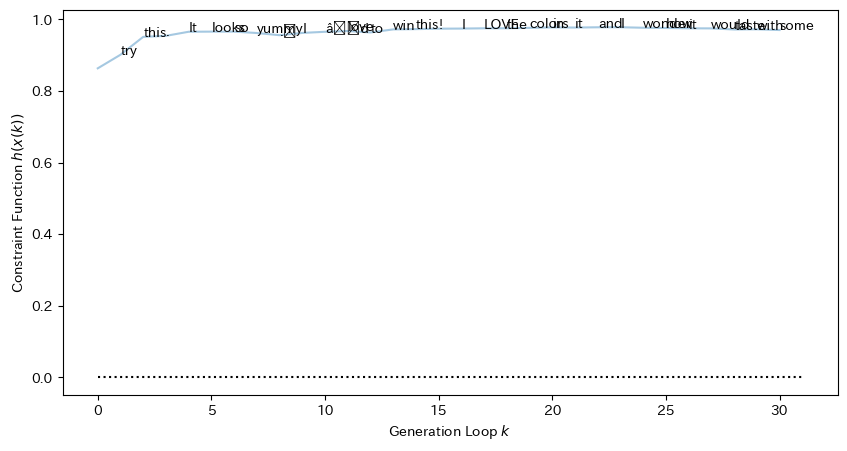

In [109]:
fig, ax = subplots(facecolor="white", figsize=(10, 5))

# 生成されたテキストの軌跡
ax.plot(htrj, c="tab:blue", alpha=0.4)
for k, ik in enumerate(res.xf[len(x0):], 1):
    ik = toint(ik)
    ax.text(k, htrj[k], ivocab[ik])

# h=0
ax.hlines(0, 0, len(htrj), ls=":", colors="k")

 
# Banされたテキストの軌跡
x0len = len(x0)
for k, banned_tokens in enumerate(res.banned_tokens_list, 1):
    banned_tokens and print(f"\n{k=} {[ivocab[i] for i in banned_tokens]}")
    for i in banned_tokens:
        x = hstack((res.xf[:x0len + k - 1].cpu(), tensor(i)))
        x_str = Gt.decode(x)
        print(x_str)
        h = clm.get_for_text(x_str)
        ax.plot([k, k], [htrj[k], h], c="tab:red", alpha=0.2)
        ax.text(k, h, ivocab[i], color="tab:red")

ax.set_xlabel("Generation Loop $k$")
ax.set_ylabel("Constraint Function $h(x(k))$")
plt.show()

In [110]:
save(fig, "E8/11.pdf")

c:\Users\omiya\OneDrive\デスクトップ\CBFLLM\myautils.py:70: UserWarning: Glyph 266 (\N{LATIN CAPITAL LETTER C WITH DOT ABOVE}) missing from current font.
  fig.savefig(fn)
c:\Users\omiya\OneDrive\デスクトップ\CBFLLM\myautils.py:70: UserWarning: Glyph 290 (\N{LATIN CAPITAL LETTER G WITH CEDILLA}) missing from current font.
  fig.savefig(fn)
c:\Users\omiya\OneDrive\デスクトップ\CBFLLM\myautils.py:70: UserWarning: Glyph 315 (\N{LATIN CAPITAL LETTER L WITH CEDILLA}) missing from current font.
  fig.savefig(fn)


# E10 Perplexityと制約関数の平均値
https://huggingface.co/blog/pref-tuning

モデル最適化の考え方

$ \min [新しい要件に対する評価] + \beta \cdot 距離([新しいモデル] , [元のモデル]) $

自分の研究

\begin{align}
\min ~& 距離([新しいモデル] , [元のモデル]) \\
\text{s.t.} ~& 新しい要件
\end{align}

距離とは？
* $D_\mathrm{KL}$は使えない・・・$\exists i , Q_i = 0$
* Perplexity $(x_f^\mathrm{NoControl} , x_f^\mathrm{Control} ; G)$
* $\mathbb E_{x_f}[\text{介入回数}]$
* $D_{JS}(P,Q)$

要件に対する評価
* $\mathbb E[h(x_f)]$

In [170]:
TOP_K = 30
TEMPERATURE = 1
MAX_NEW_TOKENS = 30
x0str = "Everyone says you will be a good researcher in the future, but"
x0 = Gtokenize(x0str)
clm.get_for_text(x0str)

0.28039589524269104

In [54]:
@no_grad
def get_perplexity(x0:Tensor, xf:Tensor, temperature:float)->float:
    x0len = len(x0)
    x = x0.clone()
    lp_sum = 0.0
    for k, iast in enumerate(xf[x0len:]):
        output = Gm(x[None])
        s = output.logits[0][-1]
        token_distribution = softmax(s/temperature, dim=0)
        i_prob = token_distribution[iast]
        lp_sum += i_prob.log()
        # print(k, Gt.decode(x), ivocab[toint(iast)], tofloat(i_prob))
        x = hstack((x, iast))
    lp_ave = lp_sum / (len(xf) - x0len)
    ppl = (-lp_ave).exp()
    return tofloat(ppl)

In [66]:
from collections import defaultdict
E10_1_xf_result = defaultdict(list)
SAMPLE_SIZE = 100

In [92]:
E10_1_xf_result = load("./E10/1_xf_result.json")

In [67]:
# NoControl
for i in range(SAMPLE_SIZE):
    print("NoControl", i)
    res_NoControl = generate_with_NoControl(
        x0=x0, temperature=TEMPERATURE, top_k=TOP_K, max_new_tokens=MAX_NEW_TOKENS
    )
    E10_1_xf_result["NoControl"].append(res_NoControl.xf)

# CBF0.8
for i in range(SAMPLE_SIZE):
    print("CBF", i)
    res_CBF = generate_with_CBFFilter(
        x0=x0, temperature=TEMPERATURE, top_k=TOP_K,
        alpha=0.8, filter=MinJSDFilter(), max_new_tokens=MAX_NEW_TOKENS
    )
    E10_1_xf_result["CBF"].append(res_CBF.xf)

# Blacklist
for i in range(SAMPLE_SIZE):
    print("Blacklist", i)
    res_Blacklist = generate_with_CBFFilter(
        x0=x0, temperature=TEMPERATURE, top_k=TOP_K,
        alpha=1.0, filter=MinJSDFilter(), max_new_tokens=MAX_NEW_TOKENS
    )
    E10_1_xf_result["Blacklist"].append(res_Blacklist.xf)

NoControl 0
NoControl 1
NoControl 2
NoControl 3
NoControl 4
NoControl 5
NoControl 6
NoControl 7
NoControl 8
NoControl 9
NoControl 10
NoControl 11
NoControl 12
NoControl 13
NoControl 14
NoControl 15
NoControl 16
NoControl 17
NoControl 18
NoControl 19
NoControl 20
NoControl 21
NoControl 22
NoControl 23
NoControl 24
NoControl 25
NoControl 26
NoControl 27
NoControl 28
NoControl 29
NoControl 30
NoControl 31
NoControl 32
NoControl 33
NoControl 34
NoControl 35
NoControl 36
NoControl 37
NoControl 38
NoControl 39
NoControl 40
NoControl 41
NoControl 42
NoControl 43
NoControl 44
NoControl 45
NoControl 46
NoControl 47
NoControl 48
NoControl 49
NoControl 50
NoControl 51
NoControl 52
NoControl 53
NoControl 54
NoControl 55
NoControl 56
NoControl 57
NoControl 58
NoControl 59
NoControl 60
NoControl 61
NoControl 62
NoControl 63
NoControl 64
NoControl 65
NoControl 66
NoControl 67
NoControl 68
NoControl 69
NoControl 70
NoControl 71
NoControl 72
NoControl 73
NoControl 74
NoControl 75
NoControl 76
NoControl

In [95]:
# CBF0.3
CBF03_xf_result = []
for i in tqdm(range(SAMPLE_SIZE)):
    res_CBF = generate_with_CBFFilter(
        x0=x0, temperature=TEMPERATURE, top_k=TOP_K,
        alpha=0.3, filter=MinJSDFilter(), max_new_tokens=MAX_NEW_TOKENS
    )
    CBF03_xf_result.append(res_CBF.xf)

C:\Users\omiya\AppData\Local\Temp\ipykernel_25688\3545441070.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(SAMPLE_SIZE)):


  0%|          | 0/100 [00:00<?, ?it/s]

In [99]:
E10_1_xf_result["CBF0.3"] = list(map(tolist,CBF03_xf_result))

In [100]:
save(E10_1_xf_result, "E10/1_xf_result.json")

In [37]:
get_perplexity(x0, res_Blacklist.xf, temperature=TEMPERATURE)

0.19398336112499237

In [75]:
E10_1_analysis_result = {}
for label, xf_list in E10_1_xf_result.items():
    item = {"ppl_list":[], "htrj_list":[]}
    for xf in tqdm(xf_list):
        xf = tensor(xf, device=x0.device)
        ppl = get_perplexity(x0, xf, temperature=TEMPERATURE)
        htrj = get_htrj(x0, xf)
        item["ppl_list"].append(ppl)
        item["htrj_list"].append(htrj)
    E10_1_analysis_result[label] = item

C:\Users\omiya\AppData\Local\Temp\ipykernel_25688\1059711326.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for xf in tqdm(xf_list):


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [102]:
CBF03_analysis_result = {"ppl_list":[], "htrj_list":[]}

for xf in tqdm(CBF03_xf_result):
    xf = tensor(xf, device=x0.device)
    ppl = get_perplexity(x0, xf, temperature=TEMPERATURE)
    htrj = get_htrj(x0, xf)
    CBF03_analysis_result["ppl_list"].append(ppl)
    CBF03_analysis_result["htrj_list"].append(htrj)
E10_1_analysis_result["CBF0.3"] = CBF03_analysis_result

C:\Users\omiya\AppData\Local\Temp\ipykernel_25688\4030391641.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for xf in tqdm(CBF03_xf_result):


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\omiya\AppData\Local\Temp\ipykernel_25688\4030391641.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xf = tensor(xf, device=x0.device)


In [115]:
save(E10_1_analysis_result, "E10/1_analysis_result.json")

In [156]:

for label, record in E10_1_analysis_result.items():
    print(label)
    print(mean(record["ppl_list"]), std(record["ppl_list"]))

NoControl
10.578233530521393 3.1075623310717315
Blacklist
12.77798972606659 7.283960897719076
CBF0.3
12.346306691169739 4.780136993042501
CBF0.8
12.411030645370483 5.612623740889551


In [111]:
E10_1_analysis_result["CBF0.8"] = E10_1_analysis_result["CBF"]

In [9]:
E10_1_analysis_result = load("E10/1_analysis_result.json")

In [118]:
E10_1_analysis_result.keys()

dict_keys(['NoControl', 'Blacklist', 'CBF0.3', 'CBF0.8'])

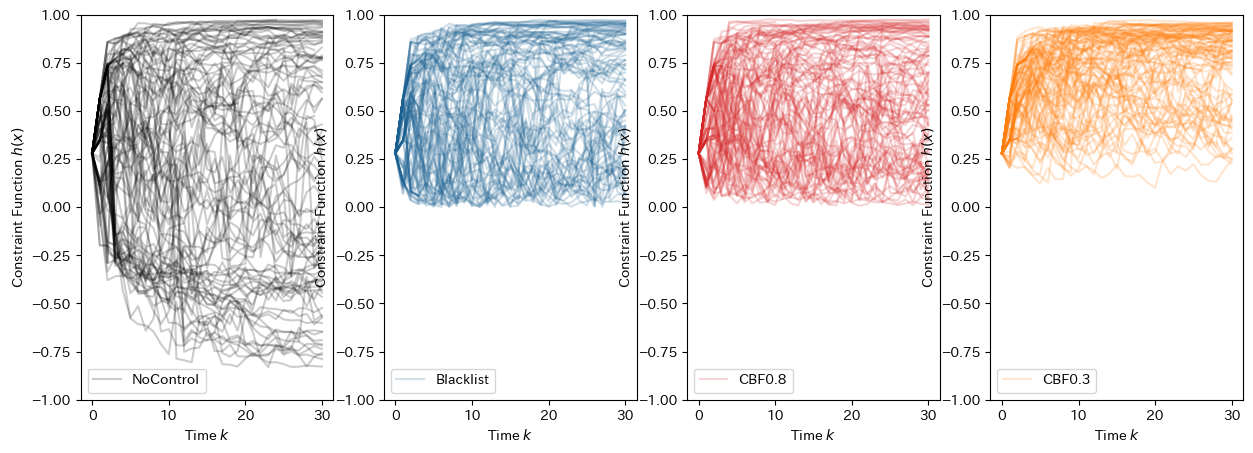

In [22]:
fig, axs = plt.subplots(1,4,figsize=(15,5))
_colors = {"NoControl":"black", "CBF0.8": "tab:red", "Blacklist": DARK_TABLEAU_COLORS["tab:blue"], "CBF0.3":"tab:orange"}
for ax,label in zip(axs,["NoControl", "Blacklist", "CBF0.8", "CBF0.3"]):
    # if label=="NoControl":
    #     continue
    color = _colors[label]
    htrj_list = E10_1_analysis_result[label]["htrj_list"]
    for i, htrj in enumerate(htrj_list):
        ax.plot(htrj, color=color, alpha=0.2, label=label if i==0 else None)
    ax.set_xlabel("Time $k$")
    ax.set_ylabel("Constraint Function $h(x)$")
    ax.set_ylim((-1,1))
    ax.legend()
# ax.set_xlim(right=10)
plt.legend()
plt.show()

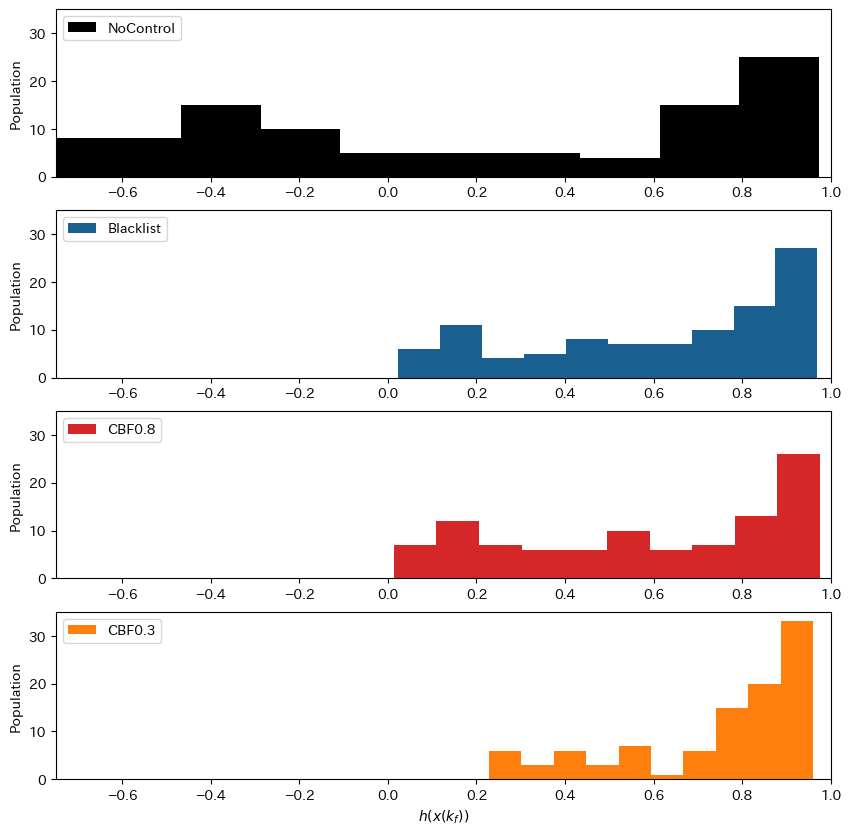

In [20]:
fig, axs = plt.subplots(4, figsize=(10,10))
_colors = {"NoControl":"black", "CBF0.8": "tab:red", "Blacklist": DARK_TABLEAU_COLORS["tab:blue"], "CBF0.3":"tab:orange"}
for ax,label in zip(axs, ["NoControl", "Blacklist", "CBF0.8", "CBF0.3"]):
    # if label=="NoControl":
    #     continue
    color = _colors[label]
    htrj_list = E10_1_analysis_result[label]["htrj_list"]
    hf_list = [htrj[-1] for htrj in htrj_list]
    ax.hist(hf_list, color=color, alpha=1.0, label=label)
    ax.set_ylabel("Population")
    ax.legend(loc="upper left")
    ax.set_xlim((-0.75, 1.0))
    ax.set_ylim(top=35)

ax.set_xlabel("$h(x(k_f))$")
plt.legend()
plt.show()

In [122]:
save(fig, "E10/1_full.pdf")

In [157]:
for label, record in E10_1_analysis_result.items():
    print(label)
    htrj_list = record["htrj_list"]
    hf_list = [htrj[-1] for htrj in htrj_list]
    print(mean(hf_list), std(hf_list))

NoControl
0.20292491406202318 0.6001058725666885
Blacklist
0.6224094355106353 0.295846887679325
CBF0.3
0.7454728078842163 0.21136907820839615
CBF0.8
0.5803121796250343 0.3024794305586913


### 介入回数は？

In [175]:
SAMPLE_SIZE = 10

In [176]:
def _make_banning_report(banned_tokens_list:List[List[int]])->dict:
    banned_tokens_counts = list(map(len,banned_tokens_list))
    banning_times = 0
    banned_tokens = 0
    for banned_tokens_k in banned_tokens_counts:
        banning_times += 1 if banned_tokens_k>0 else 0
        banned_tokens += banned_tokens_k 
    return {"banning_times":banning_times, "banned_tokens": banned_tokens}

In [180]:
banning_result = {}

In [181]:
banning_result["CBF0.3"] = []
for i in tqdm(range(SAMPLE_SIZE)):
    res_CBF03 = generate_with_CBFFilter(
        x0=x0, temperature=TEMPERATURE, top_k=TOP_K,
        alpha=0.3, filter=MinJSDFilter(), max_new_tokens=MAX_NEW_TOKENS
    )
    banning_result["CBF0.3"].append(_make_banning_report(res_CBF03.banned_tokens_list))

In [184]:
banning_result["CBF0.8"] = []
for i in tqdm(range(SAMPLE_SIZE)):
    res_CBF08 = generate_with_CBFFilter(
        x0=x0, temperature=TEMPERATURE, top_k=TOP_K,
        alpha=0.8, filter=MinJSDFilter(), max_new_tokens=MAX_NEW_TOKENS
    )
    banning_result["CBF0.8"].append(_make_banning_report(res_CBF08.banned_tokens_list))

C:\Users\omiya\AppData\Local\Temp\ipykernel_25688\4218157775.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(SAMPLE_SIZE)):


  0%|          | 0/10 [00:00<?, ?it/s]

In [187]:
banning_result["Blacklist"] = []
for i in tqdm(range(SAMPLE_SIZE)):
    res_Blacklist = generate_with_CBFFilter(
        x0=x0, temperature=TEMPERATURE, top_k=TOP_K,
        alpha=1.0, filter=MinJSDFilter(), max_new_tokens=MAX_NEW_TOKENS
    )
    banning_result["Blacklist"].append(_make_banning_report(res_Blacklist.banned_tokens_list))

C:\Users\omiya\AppData\Local\Temp\ipykernel_25688\4005727888.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(SAMPLE_SIZE)):


  0%|          | 0/10 [00:00<?, ?it/s]

In [188]:
banning_result

{'CBF0.3': [{'banning_times': 12, 'banned_tokens': 45},
  {'banning_times': 24, 'banned_tokens': 199},
  {'banning_times': 10, 'banned_tokens': 42},
  {'banning_times': 9, 'banned_tokens': 41},
  {'banning_times': 12, 'banned_tokens': 91},
  {'banning_times': 10, 'banned_tokens': 47},
  {'banning_times': 21, 'banned_tokens': 170},
  {'banning_times': 21, 'banned_tokens': 202},
  {'banning_times': 10, 'banned_tokens': 146},
  {'banning_times': 11, 'banned_tokens': 44}],
 'CBF0.8': [{'banning_times': 29, 'banned_tokens': 484},
  {'banning_times': 15, 'banned_tokens': 82},
  {'banning_times': 22, 'banned_tokens': 95},
  {'banning_times': 7, 'banned_tokens': 26},
  {'banning_times': 14, 'banned_tokens': 33},
  {'banning_times': 23, 'banned_tokens': 204},
  {'banning_times': 9, 'banned_tokens': 85},
  {'banning_times': 6, 'banned_tokens': 21},
  {'banning_times': 10, 'banned_tokens': 32},
  {'banning_times': 17, 'banned_tokens': 183}],
 'Blacklist': [{'banning_times': 15, 'banned_tokens': 8

In [189]:
save(banning_result, "E10/banning_result.json")

In [3]:
banning_result = load("E10/banning_result.json")

In [4]:
banning_result

{'CBF0.3': [{'banning_times': 12, 'banned_tokens': 45},
  {'banning_times': 24, 'banned_tokens': 199},
  {'banning_times': 10, 'banned_tokens': 42},
  {'banning_times': 9, 'banned_tokens': 41},
  {'banning_times': 12, 'banned_tokens': 91},
  {'banning_times': 10, 'banned_tokens': 47},
  {'banning_times': 21, 'banned_tokens': 170},
  {'banning_times': 21, 'banned_tokens': 202},
  {'banning_times': 10, 'banned_tokens': 146},
  {'banning_times': 11, 'banned_tokens': 44}],
 'CBF0.8': [{'banning_times': 29, 'banned_tokens': 484},
  {'banning_times': 15, 'banned_tokens': 82},
  {'banning_times': 22, 'banned_tokens': 95},
  {'banning_times': 7, 'banned_tokens': 26},
  {'banning_times': 14, 'banned_tokens': 33},
  {'banning_times': 23, 'banned_tokens': 204},
  {'banning_times': 9, 'banned_tokens': 85},
  {'banning_times': 6, 'banned_tokens': 21},
  {'banning_times': 10, 'banned_tokens': 32},
  {'banning_times': 17, 'banned_tokens': 183}],
 'Blacklist': [{'banning_times': 15, 'banned_tokens': 8

In [8]:
for label, record in banning_result.items():
    banning_times_list = [x["banning_times"] for x in record]
    banned_tokens_list = [x["banned_tokens"] for x in record]
    print(label)
    print("Banning Times:", mean(banning_times_list), std(banning_times_list))
    print("Banned Tokens:", mean(banned_tokens_list), std(banned_tokens_list))
    print()

CBF0.3
Banning Times: 14.0 5.366563145999495
Banned Tokens: 102.7 65.6080025606633

CBF0.8
Banning Times: 15.2 7.2083285163760396
Banned Tokens: 124.5 134.37354650376687

Blacklist
Banning Times: 15.7 7.7207512587830465
Banned Tokens: 452.2 700.5867255379593



# E9 ブラックリスト方式との避け方の違い
* ブラックリスト方式：CBFによる制御の$\alpha=1$と等価
* 決定論的な生成：$k_\mathrm{top}=1$としてもよい

In [123]:
def display_banned_token_lists(banned_token_lists:List[List[int]]):
    for k, banned_token_list in enumerate(banned_token_lists):
        if len(banned_token_list)==0:
            continue
        print(f"{k=}")
        print("\n".join([ivocab[i] for i in banned_token_list]))
        print()

In [141]:
TOP_K = 10
TEMPERATURE = 1 # TOP_K=1である限り関係ない
MAX_NEW_TOKENS = 30
x0str = "Everyone says you will be a good researcher in the future,"
# x0str = "前向きに検討したいとは申しました。ただし"
x0 = Gtokenize(x0str)
clm.get_for_text(x0str)

0.8471967577934265

In [142]:
nocontrol_res = generate_with_NoControl(
    x0=x0,
    temperature=TEMPERATURE,
    top_k=TOP_K,
    max_new_tokens=MAX_NEW_TOKENS
)
print("Satisfy Forward Invariance:",
      does_satisfy_forward_invariance(x0, nocontrol_res.xf))
print("Generated Text:", Gt.decode(nocontrol_res.xf))

Satisfy Forward Invariance: False
Generated Text: Everyone says you will be a good researcher in the future, but you are not a good teacher.”
I thought I had to get better at teaching because I want to be a good teacher. I thought I needed


In [154]:
blacklist_res = generate_with_CBFFilter(
    x0=x0,
    temperature=TEMPERATURE,
    top_k=TOP_K,
    alpha=1,
    filter=MinJSDFilter(),
    max_new_tokens=MAX_NEW_TOKENS
)
print(Gt.decode(blacklist_res.xf))
display_banned_token_lists(blacklist_res.banned_tokens_list)

Everyone says you will be a good researcher in the future, and I hope you will do well.”
I am grateful to the people around me who gave me this support. And I will try my best to become
k=5
not



In [155]:
cbf_res = generate_with_CBFFilter(
    x0=x0,
    temperature=TEMPERATURE,
    top_k=TOP_K,
    alpha=0.5,
    filter=MinJSDFilter(),
    max_new_tokens=MAX_NEW_TOKENS
)
print(Gt.decode(cbf_res.xf))
display_banned_token_lists(cbf_res.banned_tokens_list)

Everyone says you will be a good researcher in the future, and you must be very happy, but I feel that you have already done it well now."
I felt the need to clarify my position, "But
k=0
but
what
why

k=3
not

k=5
busy
careful
hard

k=10
sad
sorry

k=13
not
lost
never

k=14
lost



In [103]:
does_satisfy_forward_invariance(x0, blacklist_res.xf)

True